In [82]:
import os
import numpy
import csv
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [83]:
with open("resources/MainFoil_N=50.csv") as filein:
    reader = csv.reader(filein, quoting=csv.QUOTE_NONNUMERIC, skipinitialspace = True)
    x1, y1 = zip(*reader)
    x1 = numpy.asarray(x1)
    y1 = numpy.asarray(y1)

In [84]:
with open("resources/FlapFoil_N=50.csv") as filein:
    reader = csv.reader(filein, quoting=csv.QUOTE_NONNUMERIC, skipinitialspace = True)
    x2, y2 = zip(*reader)
    x2 = numpy.asarray(x2)
    y2 = numpy.asarray(y2)

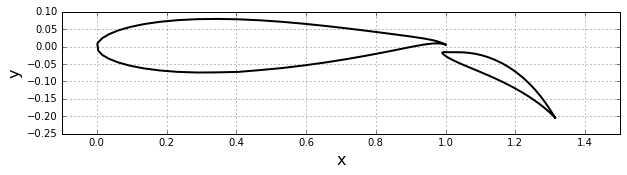

In [85]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x1, y1, x2, y2, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-.1, 1.5);
pyplot.ylim(-.25, .1);

In [86]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [87]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels eveningly over the surface of the geometery 
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """

    # create panels
    panels = numpy.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [88]:
panels1 = define_panels(x1,y1,N=50)
panels2 = define_panels(x2,y2,N=50)
panels = numpy.concatenate((panels1, panels2))

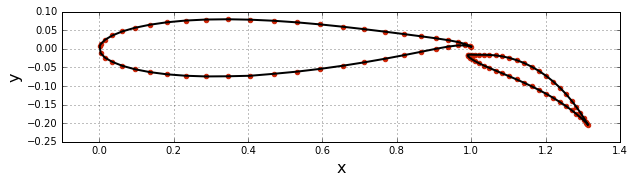

In [89]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x1, y1,x2,y2, color='k', linestyle='-', linewidth=2)
pyplot.scatter([panel.xa for panel in panels1],[panel.ya for panel in panels1], color='#CD2305')
pyplot.scatter([panel.xa for panel in panels2],[panel.ya for panel in panels2],color='#CD2305'),
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.25, 0.1);

In [90]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [91]:
# set freestream
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=0.0)

In [92]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return  ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [93]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [94]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [95]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [96]:
def kutta_condition(A_source, B_vortex):   # NOT DONE
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 2D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    N = A_source.shape[0] - 2
    k = numpy.empty([2,A_source.shape[0]+2], dtype=float)
    k[0,:-2] = B_vortex[0,:] + B_vortex[N/2,:]
    k[0,-1] = - numpy.sum(A_source[0,:N/2] + A_source[0,:N/2])    # NOT SURE
    k[0,-2] = - numpy.sum(A_source[0,N/2:] + A_source[0,N/2:])    # NOT SURE
    k[1,:-2] = B_vortex[(N/2)+1,:] + B_vortex[-1,:]
    k[1,-1] = - numpy.sum(A_source[0,:N/2] + A_source[0,:N/2])    # NOT SURE 
    k[1,-2] = - numpy.sum(A_source[0,N/2:] + A_source[0,N/2:])    # NOT SURE 
    
    return k

In [97]:
def matrix(panels,A_source,B_vortex):
    N = A_source.shape[0] - 2
    A = numpy.empty((A_source.shape[0]+2,A_source.shape[1]+2),dtype=float)
    A[:-2,:-2] = A_source
    #airfoil vortex contribution
    A[:-2,-1] = numpy.sum(B_vortex[:,:N/2], axis = 1)
    #flap vortex contribution
    A[:-2,-2] = numpy.sum(B_vortex[:,N/2:], axis = 1)
    #airfoil/foil kutta condition
    A[-2:,:] = kutta_condition(A_source,B_vortex)
    
    return A

In [98]:
A = matrix(panels,A_source,B_vortex)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__ma

In [99]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    N = numpy.shape(panels)[0]
    b = numpy.empty(N+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition for airfoil
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[(N/2)-1].beta) )
    # freesteam contribution on the Kutta condition for flap
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[(N/2)].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    return b

In [100]:
A = matrix(panels,A_source,B_vortex)
b = build_freestream_rhs(panels,freestream)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__ma

In [106]:
gamma_airfoil

0.60224204859789821

In [107]:
gamma_flap

0.62097900498826153